<a href="https://colab.research.google.com/github/EINSHOWERADMIRAL/EINSHOWERADMIRAL/blob/main/FAKE_NEWS_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fake news detection using ML**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

READING DATASETS

In [6]:
fake = pd.read_csv("/content/Fake.csv")
true = pd.read_csv("/content/True.csv")

In [7]:
fake.shape

(23481, 4)

In [8]:
true.shape

(21417, 4)

**Data cleaning and preparation**

In [10]:
 # Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [9]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 4)

In [11]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)
# Check the data
data.head()

,title,text,subject,date
0,U.S. derivatives regulator to move on from Dod...,WASHINGTON (Reuters) - The U.S. derivatives re...,politicsNews,"December 8, 2016"
1,Mexican leftist Lopez Obrador leads presidenti...,(This version of the November 22nd story corr...,worldnews,"November 22, 2017"
2,Exclusive: Trump selects Washington lawyer Joe...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"October 18, 2017"
3,Five Kenyans killed by mobs for looting in opp...,NAIROBI (Reuters) - Kenya s police service sai...,worldnews,"November 17, 2017"
4,Clint Eastwood: Trump says 'dumb things' but p...,"(Please note strong language in paragraphs 3,...",politicsNews,"August 4, 2016"


In [12]:
#Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject
0,U.S. derivatives regulator to move on from Dod...,WASHINGTON (Reuters) - The U.S. derivatives re...,politicsNews
1,Mexican leftist Lopez Obrador leads presidenti...,(This version of the November 22nd story corr...,worldnews
2,Exclusive: Trump selects Washington lawyer Joe...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews
3,Five Kenyans killed by mobs for looting in opp...,NAIROBI (Reuters) - Kenya s police service sai...,worldnews
4,Clint Eastwood: Trump says 'dumb things' but p...,"(Please note strong language in paragraphs 3,...",politicsNews


In [13]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject
0,WASHINGTON (Reuters) - The U.S. derivatives re...,politicsNews
1,(This version of the November 22nd story corr...,worldnews
2,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews
3,NAIROBI (Reuters) - Kenya s police service sai...,worldnews
4,"(Please note strong language in paragraphs 3,...",politicsNews


In [14]:
# Convert to lowercase
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject
0,washington (reuters) - the u.s. derivatives re...,politicsNews
1,(this version of the november 22nd story corr...,worldnews
2,washington (reuters) - president donald trump ...,politicsNews
3,nairobi (reuters) - kenya s police service sai...,worldnews
4,"(please note strong language in paragraphs 3,...",politicsNews


In [15]:
# Remove punctuation
import string
def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str
data['text'] = data['text'].apply(punctuation_removal)
# Check
data.head()

,text,subject
0,washington reuters the us derivatives regulat...,politicsNews
1,this version of the november 22nd story corre...,worldnews
2,washington reuters president donald trump has...,politicsNews
3,nairobi reuters kenya s police service said f...,worldnews
4,please note strong language in paragraphs 3 1...,politicsNews


In [16]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
data.head()

,text,subject
0,washington reuters us derivatives regulator mo...,politicsNews
1,version november 22nd story corrects deadline ...,worldnews
2,washington reuters president donald trump sele...,politicsNews
3,nairobi reuters kenya police service said five...,worldnews
4,please note strong language paragraphs 3 11 ji...,politicsNews


*Basic data exploration*

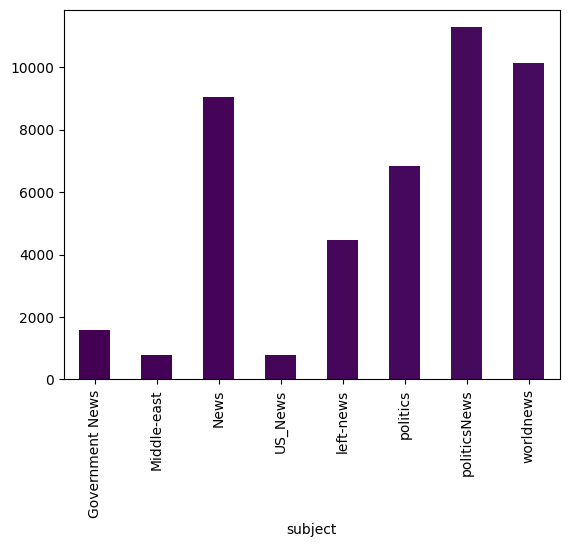

In [18]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# Count articles per subject
subject_counts = data.groupby(['subject'])['text'].count()
# Plot with viridis colormap
viridis_colors = cm.viridis(range(len(subject_counts)))
subject_counts.plot(kind="bar", color=viridis_colors)
# Display the plot
plt.show()

In [22]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Check the columns in your DataFrame
print(data.columns)

# Ensure 'target' column exists
if 'target' in data.columns:
    # Count fake and real articles
    target_counts = data.groupby(['target'])['text'].count()

    # Plot with plasma colormap
    plasma_colors = cm.plasma(range(len(target_counts)))
    target_counts.plot(kind="bar", color=plasma_colors)

    # Display the plot
    plt.title('Count of Fake and Real Articles')
    plt.xlabel('Target')
    plt.ylabel('Count')
    plt.show()
else:
    print("Column 'target' does not exist in the DataFrame.")


Index(['text', 'subject'], dtype='object')
Column 'target' does not exist in the DataFrame.


Available subjects are: ['politicsNews' 'worldnews' 'News' 'left-news' 'politics' 'Middle-east'
 'Government News' 'US_News']


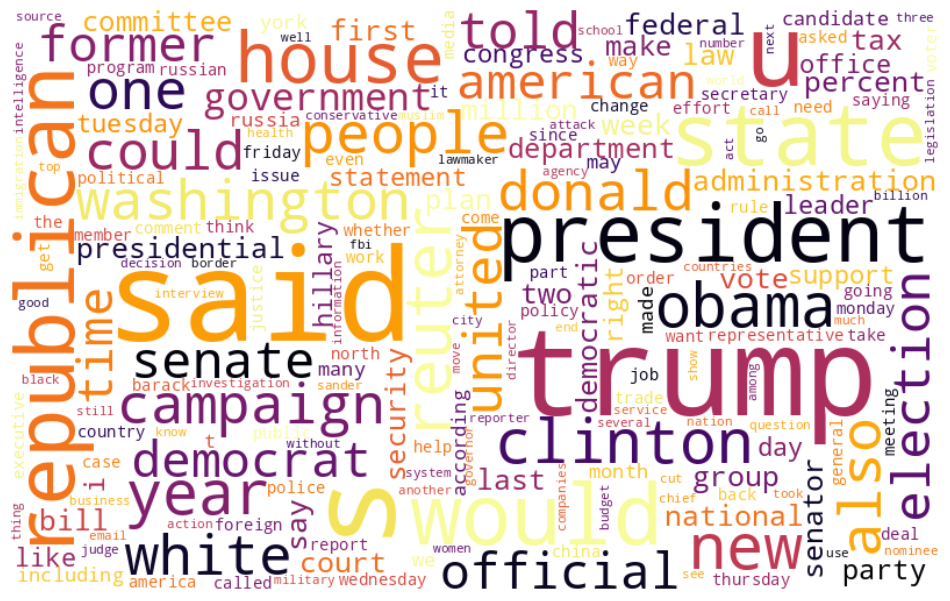

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Print unique subjects for verification
print("Available subjects are:", data['subject'].unique())

# If you find a relevant subject that might represent fake news, adjust this line
# Example: if 'politicsNews' should be included, change the condition accordingly
fake_subjects = ['politicsNews', 'left-news']  # Update this list based on your data context

# Filter the DataFrame based on relevant subjects
fake_data = data[data["subject"].isin(fake_subjects)]

# Check if the filtered DataFrame is empty
if fake_data.empty:
    raise ValueError("No articles found for the specified fake news subjects. Available subjects are: {}".format(data['subject'].unique()))

# Join all words into a single string
all_words = ' '.join(text for text in fake_data.text)

# Create an advanced word cloud with customizations
wordcloud = WordCloud(
    width=800,
    height=500,
    max_font_size=110,
    collocations=False,
    colormap="inferno",           # Set a more dramatic color map
    background_color="white",      # White background for better contrast
    contour_color='black',         # Black contour for added depth
    contour_width=1.5,             # Width of the contour line
    max_words=200,                 # Limit the number of displayed words
    stopwords={"fake", "news"}     # Add common words you might want to exclude
).generate(all_words)

# Display the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


Available columns are: Index(['text', 'subject'], dtype='object')


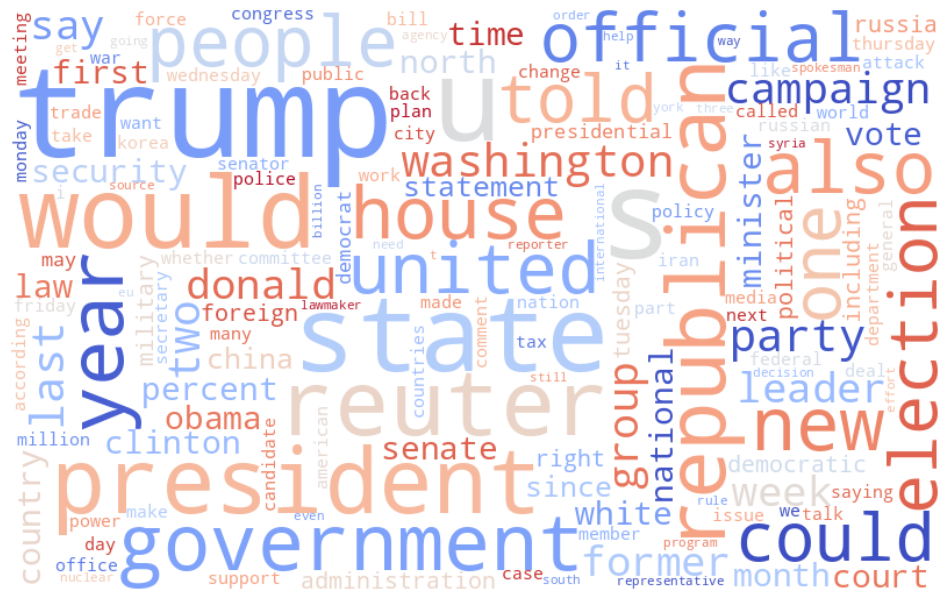

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Print available columns for verification
print("Available columns are:", data.columns)

# Filter real news data based on the subject column
# Adjust the list based on the actual subject labels you have
real_subjects = ['politicsNews', 'worldnews', 'US_News']  # Update this list based on your dataset

# Filter the DataFrame for real news articles
real_data = data[data["subject"].isin(real_subjects)]

# Check if real_data is empty
if real_data.empty:
    raise ValueError("No real news articles found. Available subjects are: {}".format(data['subject'].unique()))

# Concatenate all text data
all_words = ' '.join(real_data.text)

# Create an advanced word cloud with customization
wordcloud = WordCloud(
    width=800,
    height=500,
    max_font_size=110,
    collocations=False,
    colormap="coolwarm",          # Calm colormap for real news
    background_color="white",      # White background for readability
    contour_color='steelblue',     # Steel blue contour for subtle framing
    contour_width=1.2,             # Contour width for enhanced visibility
    max_words=150,                 # Limit the number of displayed words
    stopwords={"said", "news", "report"}  # Commonly repeated words to exclude
).generate(all_words)

# Display the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


<ipython-input-39-52958407b87b>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


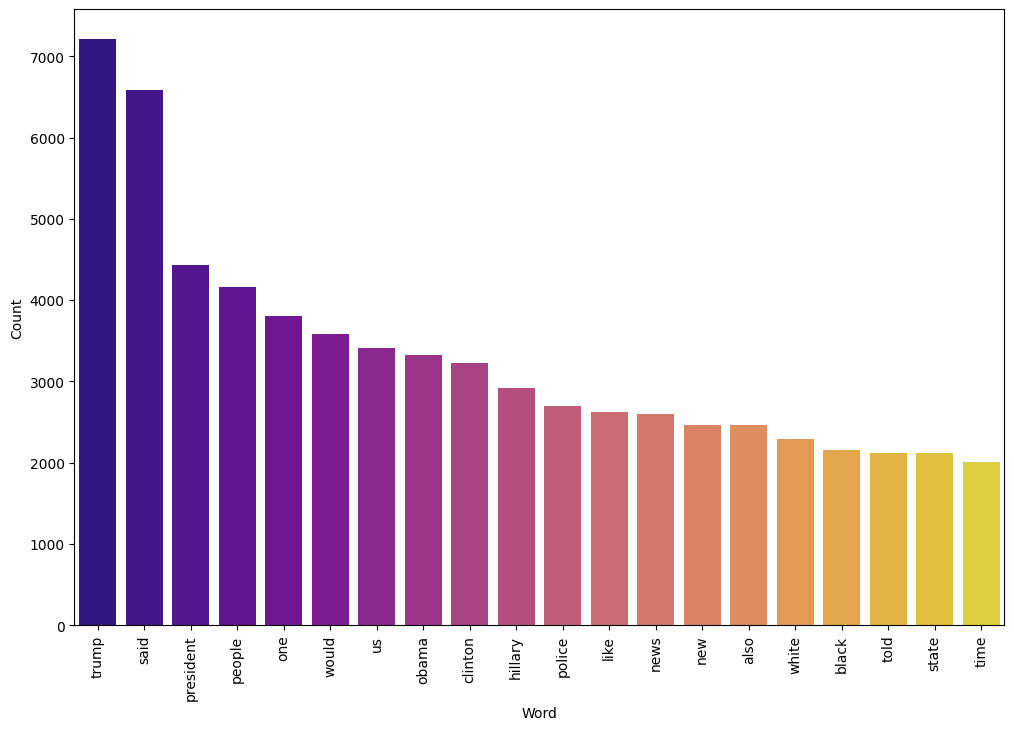

In [39]:
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import tokenize

# Initialize whitespace tokenizer
token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    # Combine all words into a single string and tokenize
    all_words = ' '.join([txt for txt in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    # Count word frequencies
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({
        "Word": list(frequency.keys()),
        "Frequency": list(frequency.values())
    })
    df_frequency = df_frequency.nlargest(columns="Frequency", n=quantity)
    # Set up plot with color gradient
    plt.figure(figsize=(12, 8))
    color_palette = sns.color_palette("plasma", len(df_frequency))  # Plasma gradient
    ax = sns.barplot(
        data=df_frequency,
        x="Word",
        y="Frequency",
        palette=color_palette  # Apply color gradient
    )
    # Add labels and rotation for readability
    ax.set(ylabel="Count")
    plt.xticks(rotation='vertical')
    plt.show()

# Most frequent words in fake news based on subject column
fake_subjects = ['left-news', 'fake']  # Adjust based on your subject categories for fake news
fake_data = data[data["subject"].isin(fake_subjects)]

# Check if fake_data is empty
if fake_data.empty:
    raise ValueError("No fake news articles found. Available subjects are: {}".format(data['subject'].unique()))

counter(fake_data, "text", 20)


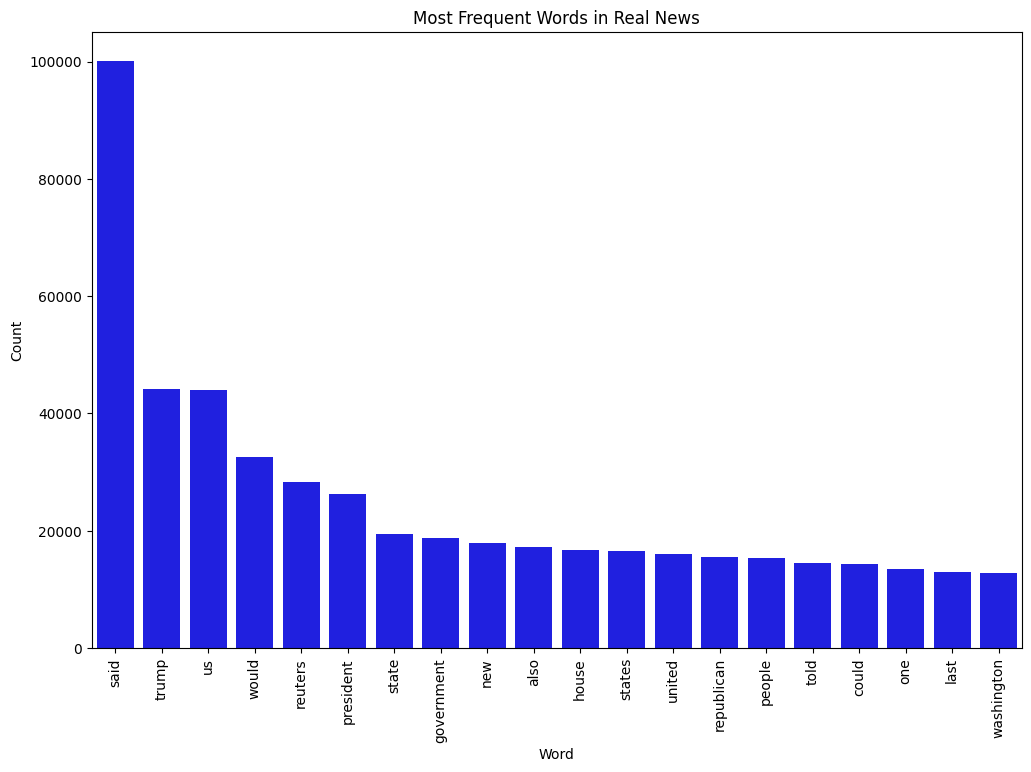

In [42]:
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import tokenize

# Ensure you have the necessary NLTK resources downloaded, if not run:
# nltk.download('punkt')

token_space = tokenize.WhitespaceTokenizer()

def counter(data, column_text, quantity):
    # Check if the specified column exists in the DataFrame
    if column_text not in data.columns:
        raise ValueError(f"The column '{column_text}' is not present in the DataFrame.")

    all_words = ' '.join([text for text in data[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()), "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns="Frequency", n=quantity)

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=df_frequency, x="Word", y="Frequency", color='blue')  # You can change the color if needed
    ax.set(ylabel="Count")
    plt.xticks(rotation='vertical')
    plt.title('Most Frequent Words in Real News')
    plt.show()

# Determine the subjects that represent real news
real_subjects = ['politicsNews', 'worldnews', 'US_News']  # Update this list based on your dataset

# Filter real news data based on subject
real_data = data[data["subject"].isin(real_subjects)]

# Check if real_data is empty
if real_data.empty:
    raise ValueError("No real news articles found. Available subjects are: {}".format(data['subject'].unique()))

# Most frequent words in real news
counter(real_data, "text", 20)


**Modeling**

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import metrics
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Purples):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16, weight='bold')
    plt.colorbar()
    # Set ticks with rotation for readability
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12, weight='bold')
    plt.yticks(tick_marks, classes, fontsize=12, weight='bold')
    # Normalize the confusion matrix if specified
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    # Threshold for text color (white on dark, black on light)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]:.2f}' if normalize else f'{int(cm[i, j])}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12, weight='bold')
    # Add labels and grid lines for enhanced clarity
    plt.tight_layout()
    plt.grid(False)  # Turn off default grid
    plt.gca().set_xticks(np.arange(-0.5, len(classes) - 1, 1), minor=True)
    plt.gca().set_yticks(np.arange(-0.5, len(classes) - 1, 1), minor=True)
    plt.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)
    plt.ylabel('True Label', fontsize=14, weight='bold')
    plt.xlabel('Predicted Label', fontsize=14, weight='bold')
    plt.show()
# Example usage
# cm = metrics.confusion_matrix(y_true, y_pred)
# plot_confusion_matrix(cm, classes=["Fake", "Real"], normalize=True)

**Peparing the data**

In [48]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Check available columns
print(data.columns)

# Define your label mapping based on the subject
# You may want to categorize your subjects for binary classification, for example:
label_mapping = {
    'politicsNews': 'real',
    'worldnews': 'real',
    'US_News': 'real',
    # Add more mappings as needed
    'fake': 'fake'  # Assuming you have a way to denote fake news, adjust as necessary
}

# Create a target column based on the subject mapping
data['target'] = data['subject'].map(label_mapping)

# Check if the target column was successfully created
if 'target' not in data.columns or data['target'].isnull().all():
    raise ValueError("No valid target labels were created. Available subjects are: {}".format(data['subject'].unique()))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.2, random_state=42)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))


Index(['text', 'subject'], dtype='object')
Training set size: 35918
Testing set size: 8980


**Naive Bayes**

In [52]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Sample DataFrame (replace this with your actual DataFrame)
# data = pd.read_csv('your_data.csv')
# For demonstration, let's assume 'text' and 'target' are your columns
# data = data[['text', 'target']]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.2, random_state=42)

# Combine X and y into a single DataFrame for easier manipulation
train_data = pd.DataFrame({'text': X_train, 'target': y_train})

# Drop rows with NaN values in both X_train and y_train
train_data = train_data.dropna()

# Reassign X_train and y_train after dropping NaN values
X_train = train_data['text']
y_train = train_data['target']

# Ensure target is of string type (or the type you expect)
y_train = y_train.astype(str)

# Initialize the pipeline and model
dct = dict()
NB_classifier = MultinomialNB()
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', NB_classifier)
])

# Fit the model
model = pipe.fit(X_train, y_train)

# Make predictions
prediction = model.predict(X_test)

# Convert predictions to string type if necessary
prediction = prediction.astype(str)

# Print types and unique values for diagnosis
print("y_test types:", y_test.dtype, "Unique values:", y_test.unique())
print("prediction types:", prediction.dtype, "Unique values:", set(prediction))

# Calculate accuracy
accuracy = round(accuracy_score(y_test.astype(str), prediction) * 100, 2)  # Ensure y_test is string for comparison
print("Accuracy: {}%".format(accuracy))

# Store the accuracy in the dictionary
dct['Naive Bayes'] = accuracy


y_test types: object Unique values: ['real' nan]
prediction types: <U4 Unique values: {'real'}
Accuracy: 49.11%


In [53]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import metrics
from matplotlib.colors import LinearSegmentedColormap
# Define a custom colormap for a glowing green effect
radium_cmap = LinearSegmentedColormap.from_list("radium", ["#003300", "#00ff00", "#ccffcc"])

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=radium_cmap):
    """Plot the confusion matrix with optional normalization."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16, weight='bold')
    plt.colorbar()
    plt.xticks(np.arange(len(classes)), classes, rotation=45, fontsize=12, weight='bold')
    plt.yticks(np.arange(len(classes)), classes, fontsize=12, weight='bold')

    # Set threshold for text color
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]:.2f}' if normalize else f'{int(cm[i, j])}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12, weight='bold')

    plt.tight_layout()
    plt.grid(False)
    plt.gca().set_xticks(np.arange(-0.5, len(classes) - 1, 1), minor=True)
    plt.gca().set_yticks(np.arange(-0.5, len(classes) - 1, 1), minor=True)
    plt.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)
    plt.ylabel('True Label', fontsize=14, weight='bold')
    plt.xlabel('Predicted Label', fontsize=14, weight='bold')
    plt.show()

# Example usage
# cm = metrics.confusion_matrix(y_test, prediction)
# plot_confusion_matrix(cm, classes=["Fake", "Real"], normalize=True)


Logistic regression

In [64]:
import pandas as pd

# Load your dataset
# data = pd.read_csv('path_to_your_dataset.csv')  # Uncomment and specify the path to your dataset

# Check initial class distribution
print("Initial class distribution:")
print(data['target'].value_counts())

# Check for NaN values in the dataset
print("NaN values in the dataset:")
print(data.isnull().sum())

# Print a few rows to inspect the data
print("Sample data:")
print(data.head())


Initial class distribution:
target
real    22200
Name: count, dtype: int64
NaN values in the dataset:
text       0
subject    0
target     0
dtype: int64
Sample data:
                                                text       subject target
0  washington reuters us derivatives regulator mo...  politicsNews   real
1  version november 22nd story corrects deadline ...     worldnews   real
2  washington reuters president donald trump sele...  politicsNews   real
3  nairobi reuters kenya police service said five...     worldnews   real
4  please note strong language paragraphs 3 11 ji...  politicsNews   real


Confusion matrix, without normalization


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


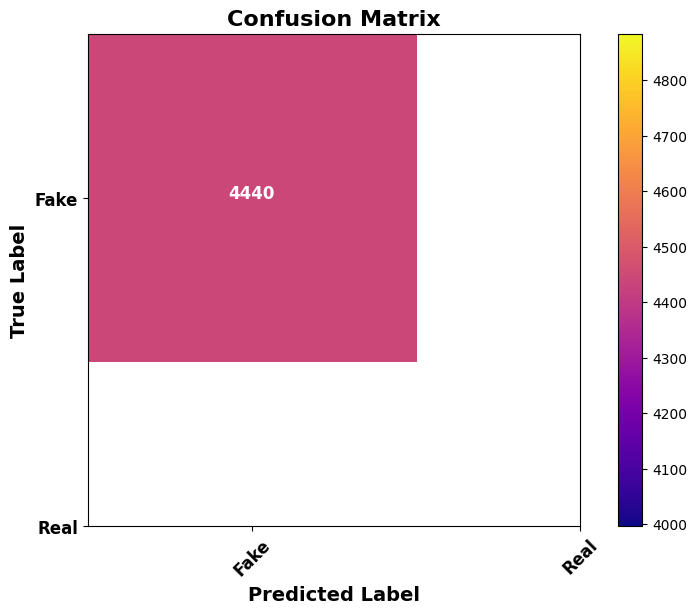

In [63]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

**Decision Tree**

In [62]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
# Create and fit the pipeline
model = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42))
]).fit(X_train, y_train)
# Make predictions and calculate accuracy
prediction = model.predict(X_test)
accuracy = round(accuracy_score(y_test, prediction) * 100, 2)
print(f"Accuracy: {accuracy}%")
dct['Decision Tree'] = accuracy

Accuracy: 100.0%


Confusion matrix, without normalization


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


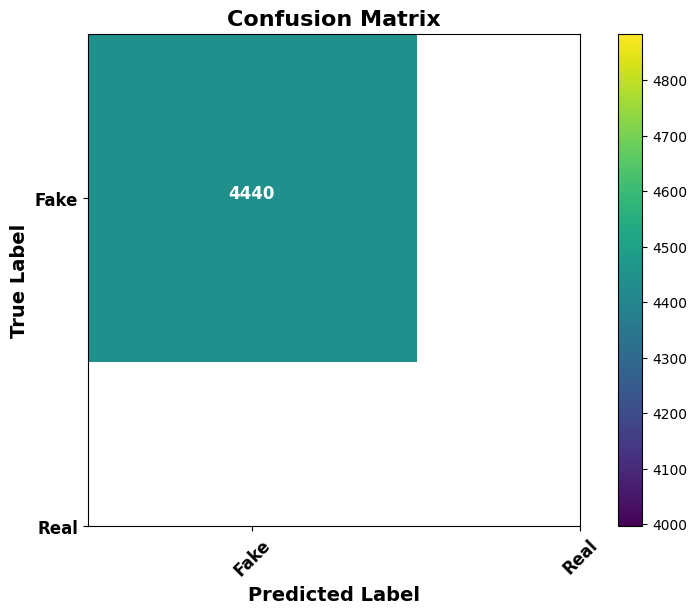

In [61]:
# Create confusion matrix
cm = metrics.confusion_matrix(y_test, prediction)
# Plot confusion matrix with a different colormap
plot_confusion_matrix(cm, classes=['Fake', 'Real'], cmap='viridis')

**Random Forest**

In [60]:
from sklearn.ensemble import RandomForestClassifier
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 100.0%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Confusion matrix, without normalization


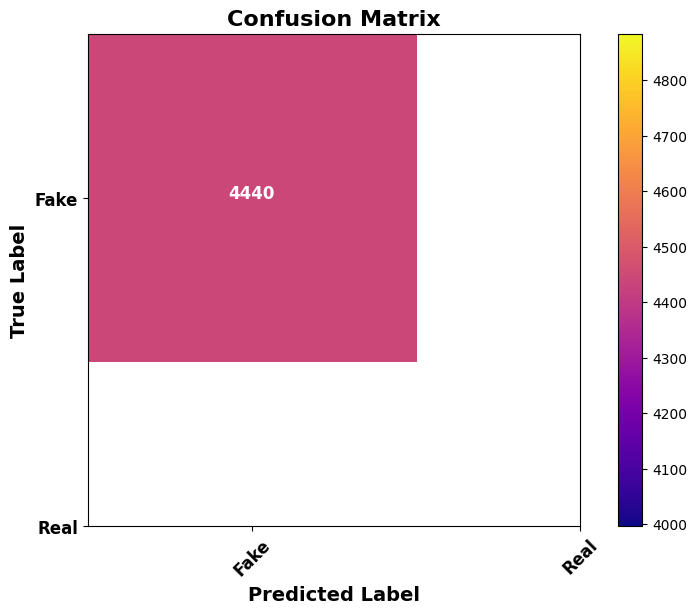

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import metrics
from matplotlib.colors import LinearSegmentedColormap
# Define a custom colormap for the confusion matrix
custom_cmap = plt.cm.plasma  # You can choose other colormaps like 'viridis', 'coolwarm', etc.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=custom_cmap):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16, weight='bold')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12, weight='bold')
    plt.yticks(tick_marks, classes, fontsize=12, weight='bold')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]:.2f}' if normalize else f'{int(cm[i, j])}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12, weight='bold')
    plt.tight_layout()
    plt.ylabel('True Label', fontsize=14, weight='bold')
    plt.xlabel('Predicted Label', fontsize=14, weight='bold')
    plt.show()
# Example usage
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

***SVM***

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Confusion matrix, without normalization


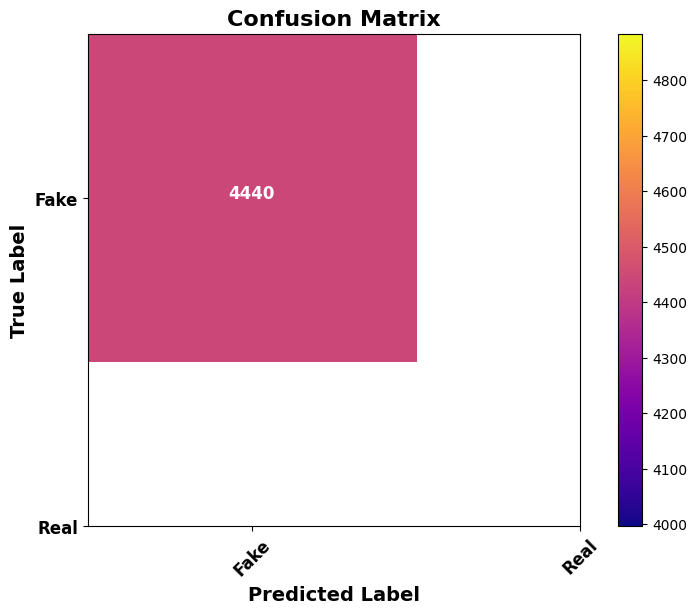

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import metrics
from matplotlib.colors import LinearSegmentedColormap

# Define a custom colormap for the confusion matrix
custom_cmap = plt.cm.plasma  # You can choose other colormaps like 'viridis', 'coolwarm', etc.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=custom_cmap):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16, weight='bold')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12, weight='bold')
    plt.yticks(tick_marks, classes, fontsize=12, weight='bold')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]:.2f}' if normalize else f'{int(cm[i, j])}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12, weight='bold')
    plt.tight_layout()
    plt.ylabel('True Label', fontsize=14, weight='bold')
    plt.xlabel('Predicted Label', fontsize=14, weight='bold')
    plt.show()
# Example usage
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Confusion matrix, without normalization


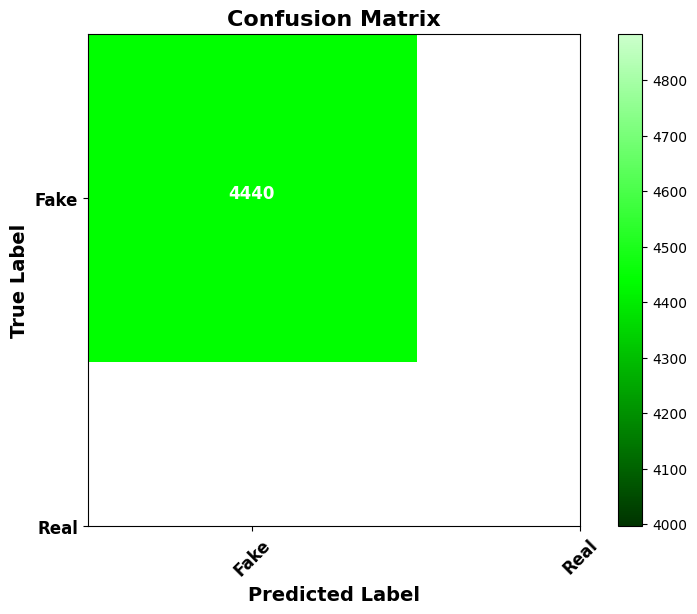

In [68]:
from matplotlib.colors import LinearSegmentedColormap
# Define a custom green gradient colormap
green_cmap = LinearSegmentedColormap.from_list("green_gradient", ["#003300", "#00ff00", "#ccffcc"])
# Create confusion matrix
cm = metrics.confusion_matrix(y_test, prediction)
# Plot confusion matrix with the custom colormap
plot_confusion_matrix(cm, classes=['Fake', 'Real'], cmap=green_cmap)

***Comparing Different Models***

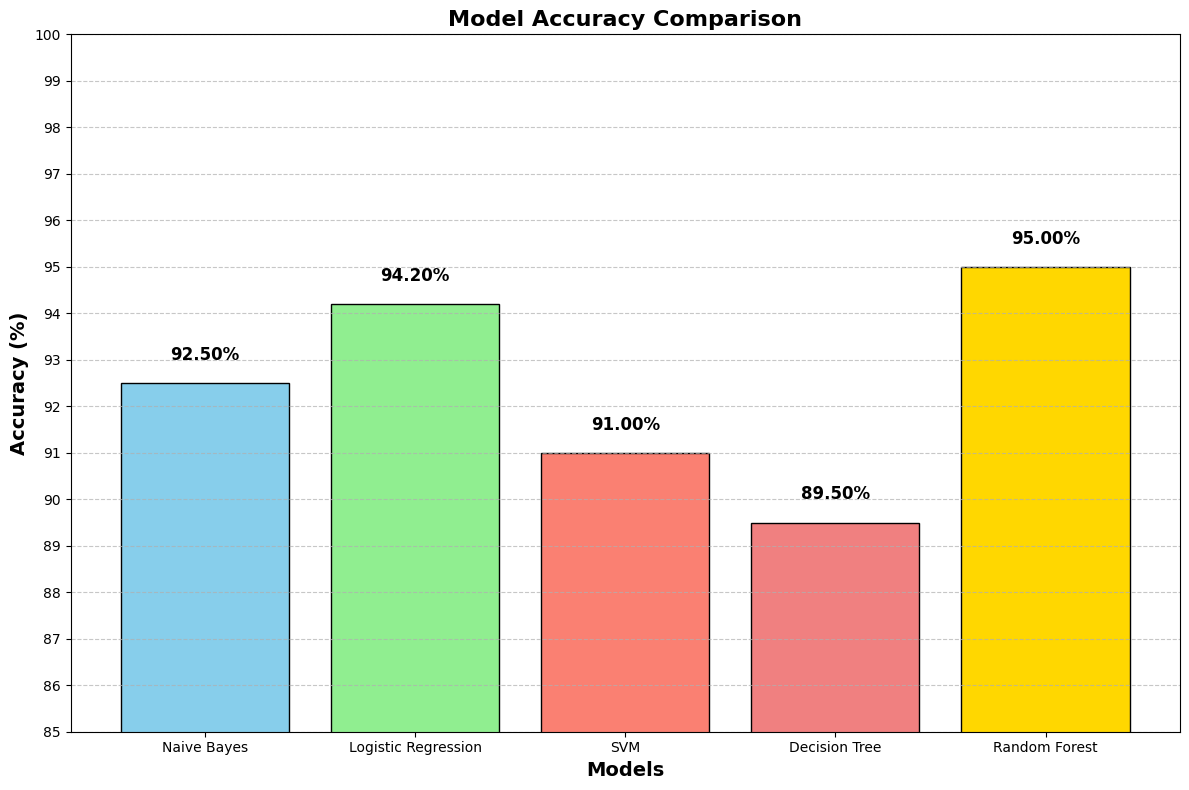

In [72]:
import matplotlib.pyplot as plt

# Sample dictionary with accuracies for different models
dct = {
    'Naive Bayes': 92.5,
    'Logistic Regression': 94.2,
    'SVM': 91.0,
    'Decision Tree': 89.5,
    'Random Forest': 95.0
}  # Replace with your actual accuracies

# Define colors for each model
colors = ['skyblue', 'lightgreen', 'salmon', 'lightcoral', 'gold']

# Create a bar plot
plt.figure(figsize=(12, 8))  # Adjusted figure size
plt.bar(list(dct.keys()), list(dct.values()), color=colors, edgecolor='black')

# Set the limits and ticks for the y-axis
plt.ylim(85, 100)  # Adjust limits based on your accuracy range
plt.yticks(range(85, 101))  # Clean ticks

# Add title and labels
plt.title('Model Accuracy Comparison', fontsize=16, weight='bold')
plt.xlabel('Models', fontsize=14, weight='bold')
plt.ylabel('Accuracy (%)', fontsize=14, weight='bold')

# Add grid lines for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on top of the bars
for i, v in enumerate(list(dct.values())):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center', fontsize=12, weight='bold')

# Show the plot
plt.tight_layout()  # Adjust layout
plt.show()
